<a href="https://colab.research.google.com/github/AntonisGantzos/Pytorch_Fake_News_detection/blob/main/Copy_of_Introduction_o_Machine_Learning_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit card binary classification
The bank collected several pieces of information from them such as:
- Marriage status
- Amount of credit given in the credit card
- Gender and Age
- A few other credit history features such as payment delays for previous monthsamounts paid in the previous months, etc.

Then, there is a binary target feature: default payment next month (target). This is the probability estimated by
the bank on whether a given customer will default (bankrupt most likely), or not.
The goal in this project is to predict that binary target variable

In [9]:
import io

import pandas as pd
import requests

# Loading the data


In [10]:
#import dataset from UC Archive
#get the file containing the data
import requests
import zipfile
from pathlib import Path

data_path=Path("/data")

credit_card_data_path =data_path / "credit_card_data"

#if the folder does not exist download it and prepare it
if credit_card_data_path.is_dir():
  print(f"{credit_card_data_path} directory already exists")
else:
  print(f"{credit_card_data_path} does not exist, creating directory...")
  credit_card_data_path.mkdir(parents=True, exist_ok=True)


# Download credit card data
with open(data_path / "data.zip", "wb") as f:
    request = requests.get("https://archive.ics.uci.edu/static/public/350/default+of+credit+card+clients.zip")
    print("Downloading credit card data...")
    f.write(request.content)

# Unzip credit card data
with zipfile.ZipFile(data_path / "data.zip", "r") as zip_ref:
    print("Unzipping credit card data...")
    zip_ref.extractall(credit_card_data_path)

/data/credit_card_data directory already exists
Unzipping credit card data...


In [11]:
df=pd.read_excel(f'{credit_card_data_path}/default of credit card clients.xls', header=1, index_col=0)

# Maybe in a non-Unix system (e.g. Windows) this path doesn't work. Check with \ instead of /

In [12]:
df.rename(columns={'default payment next month': 'target'})

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,target
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000,1,3,1,39,0,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29997,150000,1,3,2,43,-1,-1,-1,-1,0,...,8979,5190,0,1837,3526,8998,129,0,0,0
29998,30000,1,2,2,37,4,3,2,-1,0,...,20878,20582,19357,0,0,22000,4200,2000,3100,1


# Information about Dataset

Have fun with it.

In [13]:
#get additional info about our data
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   LIMIT_BAL                   30000 non-null  int64
 1   SEX                         30000 non-null  int64
 2   EDUCATION                   30000 non-null  int64
 3   MARRIAGE                    30000 non-null  int64
 4   AGE                         30000 non-null  int64
 5   PAY_0                       30000 non-null  int64
 6   PAY_2                       30000 non-null  int64
 7   PAY_3                       30000 non-null  int64
 8   PAY_4                       30000 non-null  int64
 9   PAY_5                       30000 non-null  int64
 10  PAY_6                       30000 non-null  int64
 11  BILL_AMT1                   30000 non-null  int64
 12  BILL_AMT2                   30000 non-null  int64
 13  BILL_AMT3                   30000 non-null  int64
 14  BILL_AMT4  

In [14]:
df.shape

(30000, 24)

# Feature Selection
A process to reduce the dimentionality of the input data needs to be defined, in order to "trim the fat" and keep only the relevant data to reach the goal of this project

There are 3 ways to perform supervised feature selection :
- Filter Method : Features are dropped based on their relation to the output variable (target) or how well they correlate to the output
- Wraper method : Split the data into subsets and train a model using this. Based on the model's output, features are added/subtracked and the model gets retrained.
- Intrinsic method : Combines filter and wrapper method to find the best subset

Lasso regularization is implemented to find the most "important" columns in the dataset.

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold

In [16]:
from sklearn.model_selection import train_test_split

# Segregating the Feature and Target
X = df.drop("default payment next month", axis=1).values
y = df["default payment next month"].values

# implementing Train Test Split to split the data into train/test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

print("Shape of Train Features: {}".format(X_train.shape))
print("Shape of Test Features: {}".format(X_test.shape))
print("Shape of Train Target: {}".format(y_train.shape))
print("Shape of Test Target: {}".format(y_test.shape))

Shape of Train Features: (24000, 23)
Shape of Test Features: (6000, 23)
Shape of Train Target: (24000,)
Shape of Test Target: (6000,)


In [17]:
# parameters to be tested on GridSearchCV
params = {"alpha":np.arange(0.00001, 10, 500)}

# Number of Folds and adding the random state for replication
kf=KFold(n_splits=5,shuffle=True, random_state=42)

# Initializing the Model
lasso = Lasso()

# GridSearchCV with model, params and folds.
lasso_cv=GridSearchCV(lasso, param_grid=params, cv=kf)
lasso_cv.fit(X, y)
print("Best Params {}".format(lasso_cv.best_params_))

Best Params {'alpha': 1e-05}


In [18]:
column_names=df.drop("default payment next month", axis=1).columns
print("Column Names: {}".format(column_names.values))

Column Names: ['LIMIT_BAL' 'SEX' 'EDUCATION' 'MARRIAGE' 'AGE' 'PAY_0' 'PAY_2' 'PAY_3'
 'PAY_4' 'PAY_5' 'PAY_6' 'BILL_AMT1' 'BILL_AMT2' 'BILL_AMT3' 'BILL_AMT4'
 'BILL_AMT5' 'BILL_AMT6' 'PAY_AMT1' 'PAY_AMT2' 'PAY_AMT3' 'PAY_AMT4'
 'PAY_AMT5' 'PAY_AMT6']


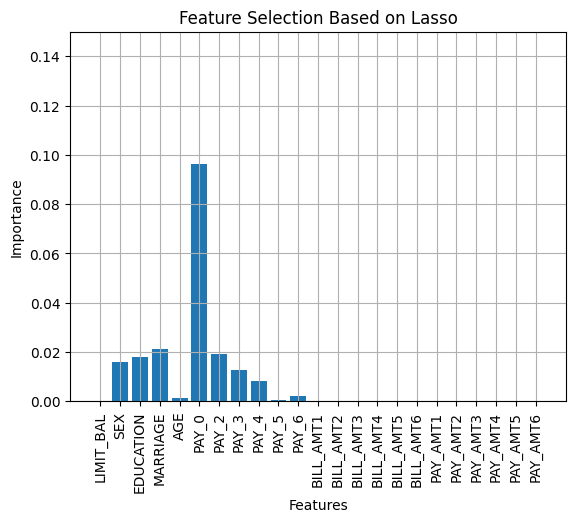

In [19]:
# calling the model with the best parameter
lasso1 = Lasso(alpha=0.00001)
lasso1.fit(X_train, y_train)

# Using np.abs() to make coefficients positive.
lasso1_coef = np.abs(lasso1.coef_)

# plotting the Column Names and Importance of Columns.
plt.bar(column_names, lasso1_coef)
plt.xticks(rotation=90)
plt.grid()
plt.title("Feature Selection Based on Lasso")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.ylim(0, 0.15)
plt.show()

In [20]:
# Subsetting the features which has more than 0.005 importance.
feature_subset=np.array(column_names)[lasso1_coef>0.005]
print("Selected Feature Columns: {}".format(feature_subset))

# Adding the target to the list of feaatures.
feature_subset=np.append(feature_subset, "default payment next month")
print("Selected Columns: {}".format(feature_subset))

Selected Feature Columns: ['SEX' 'EDUCATION' 'MARRIAGE' 'PAY_0' 'PAY_2' 'PAY_3' 'PAY_4']
Selected Columns: ['SEX' 'EDUCATION' 'MARRIAGE' 'PAY_0' 'PAY_2' 'PAY_3' 'PAY_4'
 'default payment next month']


In [21]:
final_df = df[feature_subset]
final_df.head()

,SEX,EDUCATION,MARRIAGE,PAY_0,PAY_2,PAY_3,PAY_4,default payment next month
ID,,,,,,,,
1,2,2,1,2,2,-1,-1,1
2,2,2,2,-1,2,0,0,1
3,2,2,2,0,0,0,0,0
4,2,2,1,0,0,0,0,0
5,1,2,1,-1,0,-1,0,0


In [22]:
from sklearn.model_selection import train_test_split

# Segregating the Feature and Target
X = final_df.drop("default payment next month", axis=1).values
y = final_df["default payment next month"].values

# implementing Train Test Split to split the data into train/test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

print("Shape of Train Features: {}".format(X_train.shape))
print("Shape of Test Features: {}".format(X_test.shape))
print("Shape of Train Target: {}".format(y_train.shape))
print("Shape of Test Target: {}".format(y_test.shape))

Shape of Train Features: (24000, 7)
Shape of Test Features: (6000, 7)
Shape of Train Target: (24000,)
Shape of Test Target: (6000,)


In [26]:
# reduce the rows of this df to 2000
final_df = final_df.sample(n=2000, random_state=42)

# Load classifiers
In order for predictions ot be made on the dataset, classifiers are defined and loaded witht the features that were extracted earlier. These classifiers will then be trained on the train data and be evaluated on the test data. the classifiers that will be used are :
- Logistic Regression
- KNN
- Support Vector Machine

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from tqdm import tqdm  # Importing tqdm for progress bar
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [30]:
# Initialize the classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Support Vector Machine": SVC(kernel='linear')
}

# Training and evaluating classifiers with a progress bar
for name, model in tqdm(classifiers.items(), desc="Training Classifiers"):
    print(f"\n--- Training {name} ---")
    model.fit(X_train, y_train)  # Training the model
    predictions = model.predict(X_test)  # Making predictions on test data

    # Evaluate performance
    print(f"Accuracy: {accuracy_score(y_test, predictions):.2f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))
    print("Classification Report:\n", classification_report(y_test, predictions))

Training Classifiers:   0%|          | 0/3 [00:00<?, ?it/s]


--- Training Logistic Regression ---
Accuracy: 0.81
Confusion Matrix:
 [[4540  133]
 [1008  319]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.97      0.89      4673
           1       0.71      0.24      0.36      1327

    accuracy                           0.81      6000
   macro avg       0.76      0.61      0.62      6000
weighted avg       0.79      0.81      0.77      6000


--- Training K-Nearest Neighbors ---


Training Classifiers:  67%|██████▋   | 2/3 [00:00<00:00,  2.29it/s]

Accuracy: 0.75
Confusion Matrix:
 [[3974  699]
 [ 818  509]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.85      0.84      4673
           1       0.42      0.38      0.40      1327

    accuracy                           0.75      6000
   macro avg       0.63      0.62      0.62      6000
weighted avg       0.74      0.75      0.74      6000


--- Training Support Vector Machine ---


Training Classifiers: 100%|██████████| 3/3 [00:23<00:00,  7.83s/it]

Accuracy: 0.81
Confusion Matrix:
 [[4522  151]
 [1001  326]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.97      0.89      4673
           1       0.68      0.25      0.36      1327

    accuracy                           0.81      6000
   macro avg       0.75      0.61      0.62      6000
weighted avg       0.79      0.81      0.77      6000

